In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time

from util import *
from data_loader import * 
import scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [150]:
data = load_10x_1k() ## 1k brain cells 
sc.pp.filter_genes(data,min_counts=1*data.shape[0])
# data = data[:,[0,1,2,3,4,5]]
print(data)

AnnData object with n_obs × n_vars = 931 × 1770 
    var_keys = ['n_counts']


In [152]:
data_sub = sd.subsamp_anndata(data,10,800)

#time start: 0.0s
before cell subsamp (931, 1770)
after cell subsamp (800, 1770)
#time sub-sample cells: 0.0179s
[[ 1.  1.  0. ...  2. 56.  7.]
 [ 1.  2.  1. ...  4. 41.  4.]
 [ 3.  0.  2. ...  2. 22.  0.]
 ...
 [ 2.  1.  1. ...  5. 60.  0.]
 [ 2.  4.  4. ...  5. 74.  4.]
 [ 5.  2.  3. ...  3. 43.  1.]]
[[ 1  1  0 ...  2 56  7]
 [ 1  2  1 ...  4 41  4]
 [ 3  0  2 ...  2 22  0]
 ...
 [ 2  1  1 ...  5 60  0]
 [ 2  4  4 ...  5 74  4]
 [ 5  2  3 ...  3 43  1]]
#time sub-sample counts: 3.2151s



In [3]:
data_13m = load_10x_1_3mil()
sc.pp.filter_genes(data_13m,min_counts=5*data_13m.shape[0])

In [6]:
Nc,G = data_13m.shape
Nr = data_13m.X.sum()/Nc
B = Nc*Nr
Nr_bar = Nr/G
print(B,Nc,Nr,Nr_bar)

2386569984.0 1306127 1827.2112773107056 12.100736935832487


In [81]:
B_sub_list = [int(B/10000),int(B/5000),int(B/2000),int(B/1000)]
param=[]
for B_sub in B_sub_list:
    for Nr_bar in [0.1,0.2,0.5,1,2,3,4,5,8,10]:
        param.append((B_sub,Nr_bar,Nr_bar*G,int(B_sub/Nr_bar/G)))

In [82]:
data_subsamp = {}
for i in range(len(param)):
    _,Nr_bar_,Nr_,Nc_ = param[i]
    data_subsamp[param[i]]=sd.subsamp_anndata(data_13m,Nr_,Nc_)


#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (15805, 151)
#time sub-sample cells: 0.1561s
## 5000 cells processed
## 10000 cells processed
## 15000 cells processed
#time sub-sample counts: 18.2360s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (7902, 151)
#time sub-sample cells: 0.1370s
## 5000 cells processed
#time sub-sample counts: 8.9517s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (3161, 151)
#time sub-sample cells: 0.1066s
#time sub-sample counts: 3.9515s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (1580, 151)
#time sub-sample cells: 0.0834s
#time sub-sample counts: 1.9500s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (790, 151)
#time sub-sample cells: 0.1033s
#time sub-sample counts: 1.0538s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (526, 151)
#time sub-sample cells: 0.0889s
#time sub-sample counts: 0.7433s

#t

#time sub-sample counts: 2.7223s

#time start: 0.0s
before cell subsamp (1306127, 151)
after cell subsamp (1580, 151)
#time sub-sample cells: 0.1121s
#time sub-sample counts: 2.2115s



In [83]:
gamma_c = sd.sf(data_13m,verbose=False)
M,M_ml,gene_list = sd.dd_moment_anndata(data_13m,gamma_c=gamma_c,verbose=False)

In [84]:
M_sub,Mml_sub = {},{}
for key in data_subsamp.keys():
    gamma_c = sd.sf(data_subsamp[key],verbose=False)
    M_sub[key],Mml_sub[key],_ = sd.dd_moment_anndata(data_subsamp[key],gamma_c=gamma_c,verbose=False)

In [95]:
(cv**2).mean()

1.652677967338842

In [94]:
np.log10((cv**2).mean())

0.21818823733867598

In [88]:
err_list_tot_ = {}
err_list_ml_tot_ = {}
Nr_bar_list_tot_ = {}
Nc_list_tot_ = {}

for B_sub in B_sub_list:
    err_list_ = []
    err_list_ml_ = []
    Nr_bar_list_ = []
    Nc_list_ = []
    for key in data_subsamp.keys():
        B_,Nr_bar_,Nr_,Nc_ = key
        if B_ == B_sub:
            _,_,cv_dd,_= sd.basic_cal(M_sub[key])
            _,_,cv_ml,_= sd.basic_cal(Mml_sub[key])
            _,_,cv,_= sd.basic_cal(M)
            err_list_.append(np.log10(np.mean((cv_dd-cv)**2)))
            err_list_ml_.append(np.log10(np.mean((cv_dd-cv_ml)**2)))
            Nr_bar_list_.append(Nr_bar_)
            Nc_list_.append(Nc_)
            
    err_list_ = np.array(err_list_)
    err_list_ml_ = np.array(err_list_ml_)
    Nr_bar_list_ = np.array(Nr_bar_list_)
    Nc_list_ = np.array(Nc_list_)
    
    sort_idx = np.argsort(Nr_bar_list_)
    err_list_ = err_list_[sort_idx]
    err_list_ml_ = err_list_ml_[sort_idx]
    Nr_bar_list_ = Nr_bar_list_[sort_idx]
    Nc_list_ = Nc_list_[sort_idx]
            
    err_list_tot_[B_sub] = err_list_
    err_list_ml_tot_[B_sub] = err_list_ml_
    Nr_bar_list_tot_[B_sub] = Nr_bar_list_
    Nc_list_tot_[B_sub] = Nc_list_

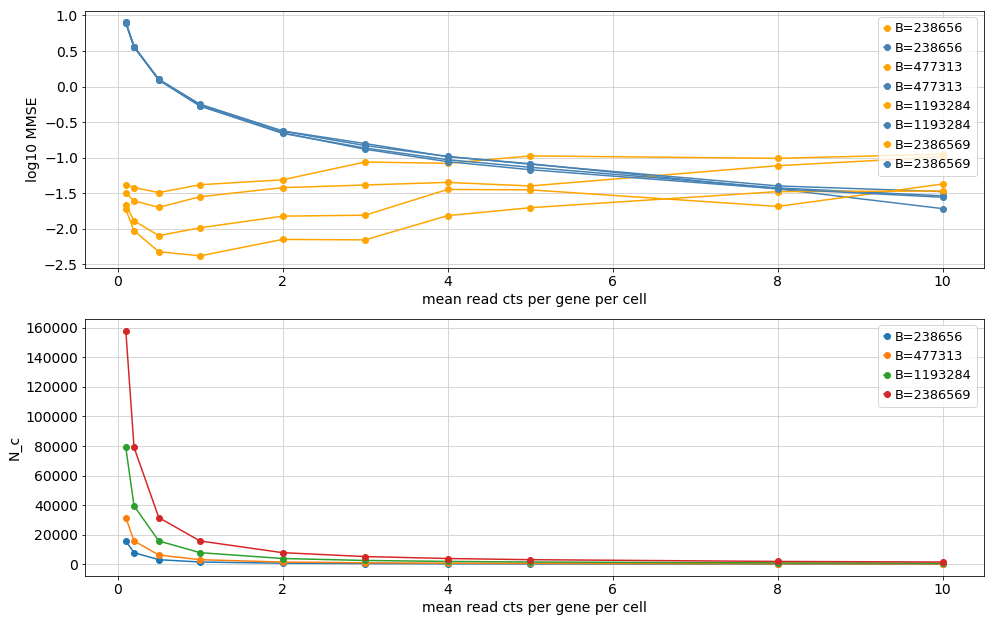

In [90]:
plt.figure(figsize=[16,10])
plt.subplot(211)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],err_list_tot_[B_sub],marker='o',label='B=%d'%B_sub,color='orange')
    plt.plot(Nr_bar_list_tot_[B_sub],err_list_ml_tot_[B_sub],marker='o',label='B=%d'%B_sub,color='steelblue')
plt.ylabel('log10 MMSE')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.subplot(212)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],Nc_list_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('N_c')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.show()

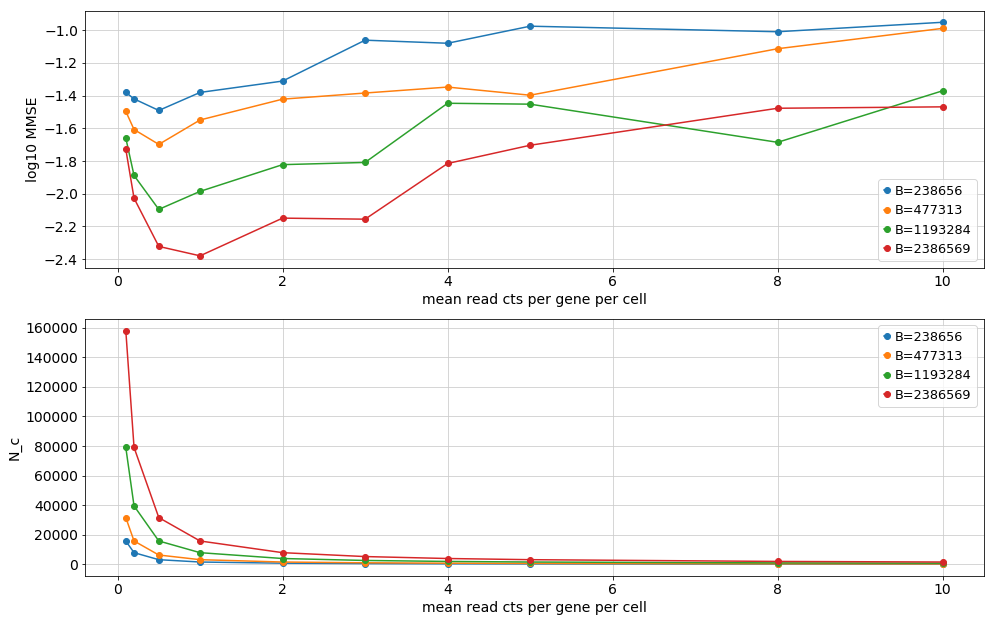

In [86]:
plt.figure(figsize=[16,10])
plt.subplot(211)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],err_list_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('log10 MMSE')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.subplot(212)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],Nc_list_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('N_c')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.show()

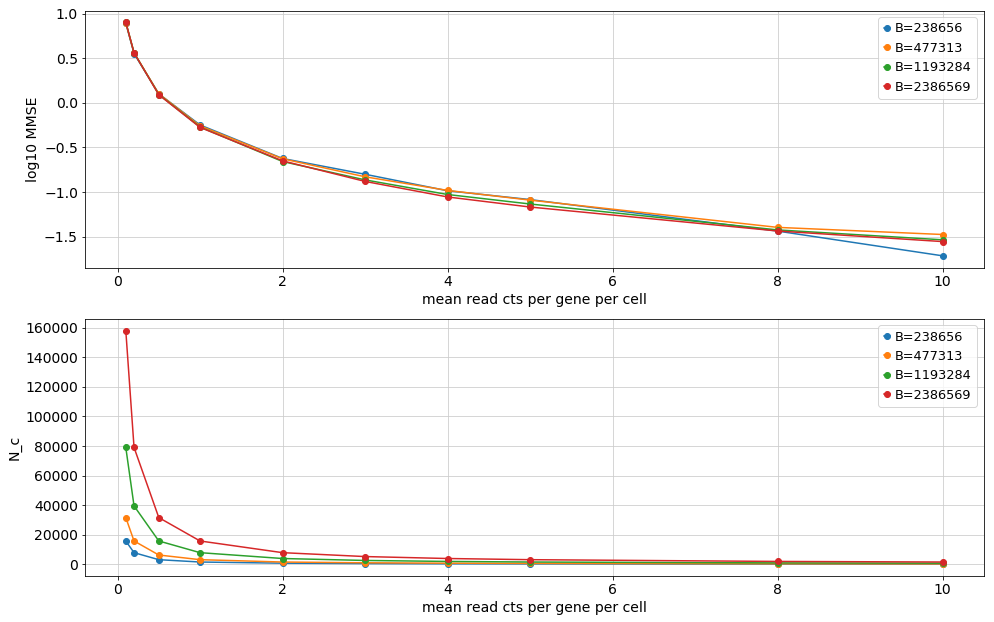

In [91]:
plt.figure(figsize=[16,10])
plt.subplot(211)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],err_list_ml_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('log10 MMSE')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.subplot(212)
for B_sub in B_sub_list:
    plt.plot(Nr_bar_list_tot_[B_sub],Nc_list_tot_[B_sub],marker='o',label='B=%d'%B_sub)
plt.ylabel('N_c')
plt.xlabel('mean read cts per gene per cell')
plt.legend()
plt.show()